In [1]:
# CNN으로 숫자 분류기 구현해보기
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("CURRENT TF VERSION IS [%s]" % (tf.__version__))
print ("PACKAGES LOADED")

CURRENT TF VERSION IS [1.1.0]
PACKAGES LOADED


In [2]:
#LOAD MNIST dataset
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("MNIST ready")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
MNIST ready


In [3]:
# DEFINE MODEL

# NETWORK TOPOLOGIES
# input 이미지의 갯수
n_input    = 784
# 컨볼루션 필터의 갯수
n_channel  = 64 
# 아웃풋 갯수
n_classes  = 10  

# INPUTS AND OUTPUTS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
    
# NETWORK PARAMETERS
stddev = 0.1
weights = {
    'c1': tf.Variable(tf.random_normal([7, 7, 1, n_channel], stddev=stddev)),
    'd1': tf.Variable(tf.random_normal([14*14*64, n_classes], stddev=stddev))
}
biases = {
    'c1': tf.Variable(tf.random_normal([n_channel], stddev=stddev)),
    'd1': tf.Variable(tf.random_normal([n_classes], stddev=stddev))
}
print ("NETWORK READY")

NETWORK READY


In [4]:
# DEFINE GRAPH

# MODEL
def CNN(_x, _w, _b):
    # RESHAPE
    # [-1, 28, 28, 1]의 의미
    # -1은 몇개가 들어올지 모르겠다.
    # 28,28,1 은 28x28 흑백이미지로 만들겠다는 것.
    _x_r = tf.reshape(_x, shape=[-1, 28, 28, 1])
    
    # 아래 4단계는 컨볼루션 한세트로 그냥 외우자
    # 물론 응용하고 싶으면 응용해도 되지만.
    # CONVOLUTION
    _conv1 = tf.nn.conv2d(_x_r, _w['c1'], strides=[1, 1, 1, 1], padding='SAME')
    # ADD BIAS
    _conv2 = tf.nn.bias_add(_conv1, _b['c1'])
    # RELU
    _conv3 = tf.nn.relu(_conv2)
    # MAX-POOL
    _pool  = tf.nn.max_pool(_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    
    # VECTORIZE
    # 컨볼루션 된 데이터를 한줄로 데이터를 변환하는 것
    _dense = tf.reshape(_pool, [-1, _w['d1'].get_shape().as_list()[0]])
    # DENSE
    # logit을 만드는 것.
    _logit = tf.add(tf.matmul(_dense, _w['d1']), _b['d1'])
    _out = {
        'x_r': _x_r, 'conv1': _conv1, 'conv2': _conv2, 'conv3': _conv3
        , 'pool': _pool, 'dense': _dense, 'logit': _logit
    }
    return _out

# PREDICTION
cnnout = CNN(x, weights, biases)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y, logits=cnnout['logit']))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(cnnout['logit'], 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


In [6]:
# saver
savedir = "nets/CNN_mnist_simple/"
saver = tf.train.Saver(max_to_keep=3)
save_step = 4
if not os.path.exists(savedir):
    os.makedirs(savedir)
print ("SAVER READY")

SAVER READY


In [7]:
# RUN

# PARAMETERS
training_epochs = 10
batch_size      = 100
display_step    = 4
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
# OPTIMIZE
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # ITERATION
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feeds = {x: batch_xs, y: batch_ys}
        sess.run(optm, feed_dict=feeds)
        avg_cost += sess.run(cost, feed_dict=feeds)
    avg_cost = avg_cost / total_batch
    # DISPLAY
    if (epoch+1) % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
        feeds = {x: batch_xs, y: batch_ys}
        train_acc = sess.run(accr, feed_dict=feeds)
        print ("TRAIN ACCURACY: %.3f" % (train_acc))
        feeds = {x: mnist.test.images, y: mnist.test.labels}
        # [:100, :]를 써서 100개씩 돌아가도록 할 수 있음.
        #feeds = {x: mnist.test.images[:100, :], y: mnist.test.labels[:100, :]}
        test_acc = sess.run(accr, feed_dict=feeds)
        print ("TEST ACCURACY: %.3f" % (test_acc))
    # SAVE
    # 매우 간단
    if (epoch+1) % save_step == 0:
        savename = savedir+"net-"+str(epoch+1)+".ckpt"
        saver.save(sess, savename)
        print ("[%s] SAVED." % (savename))
print ("OPTIMIZATION FINISHED")

KeyboardInterrupt: 

In [8]:
# 텐서플로는 쉽게 저장하고 쉽게 불러올 수 있도록 만들어져 있다.
# 위에서 지나치게 긴 학습 시간때문에 Kernel-Interrupt를 걸은 상태라
# 실행은 제한적일 것.(돌린 epoch수 만큼만 저장되는 듯)

do_restore = 0
if do_restore == 1:
    sess = tf.Session()
    epoch = 10
    savename = savedir+"net-"+str(epoch)+".ckpt"
    saver.restore(sess, savename)
    print ("NETWORK RESTORED")
else:
    print ("DO NOTHING")

DO NOTHING


In [9]:
# LET'S SEE HOW CNN WORKS
# 네트워크가 흘러가는데 중간중간 흘러가는 과정을 볼 수 있다.
input_r = sess.run(cnnout['x_r'], feed_dict={x: trainimg[0:1, :]})
conv1   = sess.run(cnnout['conv1'], feed_dict={x: trainimg[0:1, :]})
conv2   = sess.run(cnnout['conv2'], feed_dict={x: trainimg[0:1, :]})
conv3   = sess.run(cnnout['conv3'], feed_dict={x: trainimg[0:1, :]})
pool    = sess.run(cnnout['pool'], feed_dict={x: trainimg[0:1, :]})
dense   = sess.run(cnnout['dense'], feed_dict={x: trainimg[0:1, :]})
out     = sess.run(cnnout['logit'], feed_dict={x: trainimg[0:1, :]}) 

Size of 'input_r' is (1, 28, 28, 1)
Label is 7


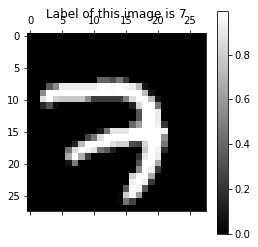

In [10]:
# input_r = sess.run(cnnout['x_r'], feed_dict={x: trainimg[0:1, :]})

print ("Size of 'input_r' is %s" % (input_r.shape,))
label = np.argmax(trainlabel[0, :])
print ("Label is %d" % (label))

# PLOT
plt.matshow(input_r[0, :, :, 0], cmap=plt.get_cmap('gray'))
plt.title("Label of this image is " + str(label) + "")
plt.colorbar()
plt.show()

SIZE OF 'CONV1' IS (1, 28, 28, 64)


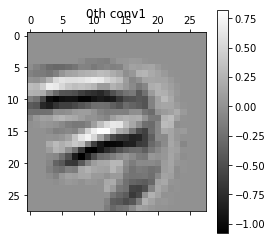

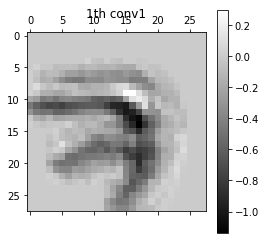

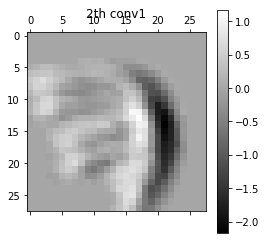

In [11]:
# conv1   = sess.run(cnnout['conv1'], feed_dict={x: trainimg[0:1, :]})

print ("SIZE OF 'CONV1' IS %s" % (conv1.shape,))
for i in range(3):
    plt.matshow(conv1[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv1")
    plt.colorbar()
    plt.show()

SIZE OF 'CONV2' IS (1, 28, 28, 64)


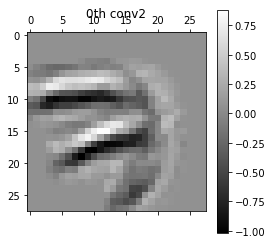

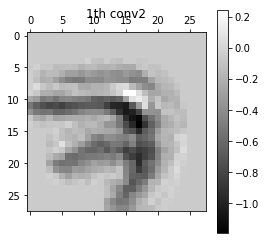

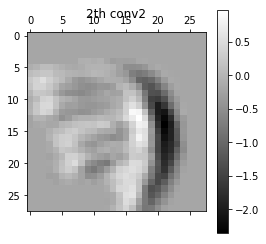

In [12]:
# conv2   = sess.run(cnnout['conv2'], feed_dict={x: trainimg[0:1, :]})
# CONV + BIAS
# Bias는 y축의 범위 자체를 변경 시켰다.

print ("SIZE OF 'CONV2' IS %s" % (conv2.shape,))
for i in range(3):
    plt.matshow(conv2[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv2")
    plt.colorbar()
    plt.show()

SIZE OF 'CONV3' IS (1, 28, 28, 64)


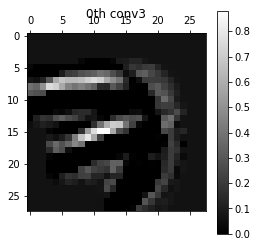

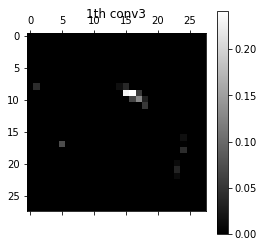

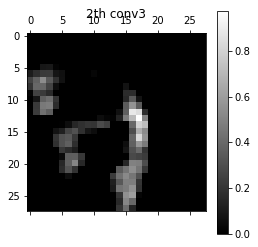

In [13]:
# conv3   = sess.run(cnnout['conv3'], feed_dict={x: trainimg[0:1, :]})
# CONV + BIAS + RELU
# ReLU는 0이 굉장히 많아진걸 볼 수 있다.
# Bias의 역할이 이래서 중요하다. Bias의 크기에 따라 ReLU를 통과하는 픽셀의 수가
# 바뀌기 때문.

print ("SIZE OF 'CONV3' IS %s" % (conv3.shape,))
for i in range(3):
    plt.matshow(conv3[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv3")
    plt.colorbar()
    plt.show()

SIZE OF 'POOL' IS (1, 14, 14, 64)


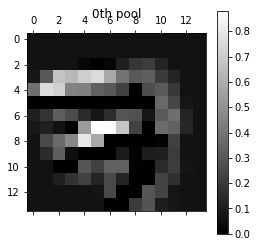

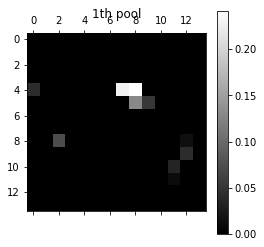

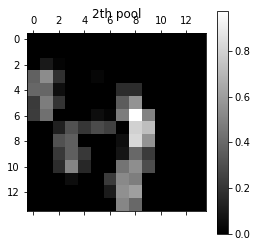

In [14]:
# pool    = sess.run(cnnout['pool'], feed_dict={x: trainimg[0:1, :]})
# MAXPOOL

print ("SIZE OF 'POOL' IS %s" % (pool.shape,))
for i in range(3):
    plt.matshow(pool[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th pool")
    plt.colorbar()
    plt.show()

SIZE OF 'DENSE' IS (1, 12544)
SIZE OF 'OUT' IS (1, 10)


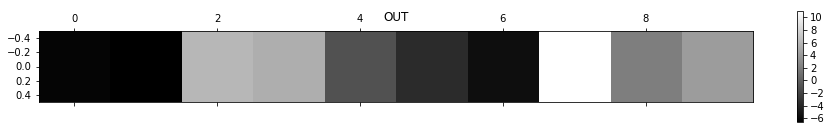

In [15]:
# dense   = sess.run(cnnout['dense'], feed_dict={x: trainimg[0:1, :]})
# out     = sess.run(cnnout['logit'], feed_dict={x: trainimg[0:1, :]})
# DENSE

print ("SIZE OF 'DENSE' IS %s" % (dense.shape,))
print ("SIZE OF 'OUT' IS %s" % (out.shape,))
plt.matshow(out, cmap=plt.get_cmap('gray'))
plt.title("OUT")
plt.colorbar()
plt.show()

SIZE OF 'WC1' IS (7, 7, 1, 64)


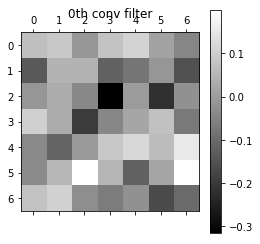

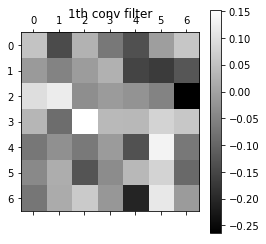

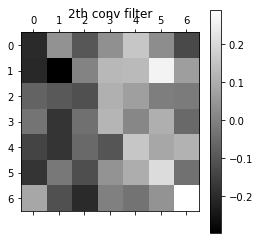

In [18]:
# CONVOLUTION FILTER
# 학습된 필터를 아래와 같이 확인할 수 있다.

wc1 = sess.run(weights['c1'])
print ("SIZE OF 'WC1' IS %s" % (wc1.shape,))
for i in range(3):
    plt.matshow(wc1[:, :, 0, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv filter")
    plt.colorbar()
    plt.show()

In [ ]:
# saver에 대해 마지막으로 언급했다
# save할 때는 saver.save
# load할 때는 saver.restore